In [1]:
%matplotlib inline
import numpy as np  #better explicit than implicit
from numba import njit,jit, config,cuda  #Libraries for GPU implementation and HIgh performance compiler
import matplotlib.pyplot as plt
from timeit import default_timer as timer  

#Not mandatory, these are only for debugging gpu
from wurlitzer import pipes
%load_ext wurlitzer

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
#set the precision type
my_type= np.float64

#do u have GPU?
using_GPU= 1

if(using_GPU):   #njit cannot optimize cuda kernels
    config.DISABLE_JIT = True

In [3]:
#cannot use njit if lambda function is an argument
def constructA(diag_info,div_factor, n):
    """This function construct a symmetric FD matrix by just sending a vector with
    the constants present in the approximation, the 1st value of the vector should be the
    constant associated with the main diagonal, the second value with 2nd diagonal and so on"""
    diag_len=len(diag_info)
    A = np.zeros((n,n),dtype=my_type)
    for i in range(diag_len):
        diag_strip = diag_info[i]*np.ones(n-i)
        A += np.diag(diag_strip,i)
    A += np.tril(A.T,-1) 
    return A/div_factor

def finDif(omega,f,n,bc):
    """Set the matrices A,b for Finite diferences Method taking in consideration
    the boundary conditions"""
    h = (omega[1] - omega[0])/(n-1)
    diag_info = [30.0,-16.0,1.0]

    A = constructA(diag_info,12.0*h*h, n)   #defining A matrix
    x = np.linspace(omega[0], omega[1], n)
    b = np.zeros_like(x,dtype=my_type)
    b = f(x)   #defining b vector
    
    # Applying boundary conditions
    A[:,0] = A[0,:] =  A[-1,:] = A[:,-1] = 0.0
    A[0,0] = A[-1,-1] = 1.0
    b[0] = bc[0]
    b[-1] = bc[1]

    return A, b

Call the function using:

In [4]:
omega = [0.0,np.pi]
f = lambda x : np.sin(x)
n = 100
bc = [0.0,0.0]

start = timer()
A, b = finDif(omega, f, n, bc)
print("Time spent by finite diference matrix construction:", timer()-start)

Time spent by finite diference matrix construction: 0.0015936910058371723


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [5]:
@cuda.jit
def A_pivot_GPU(_A,tol,N):
    """Obtains A pivoted version using GPU (Nvidia)"""
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Number of threads per block
    bw = cuda.blockDim.x
    # Thread position in a general form
    Th_pos = tx + ty * bw
    
    grid_LU = cuda.cg.this_grid()  #grid synchronization

    if(Th_pos<N):
        for i in range(N-1):

            if (abs(_A[i,i]) < tol):  #criteria
                raise Exception("Pivot does not meet tolerance")
            
            if(Th_pos>i):
                _A[Th_pos,i] /= _A[i,i] # dividing partial columns by pivot
                cuda.syncthreads()
                
                for j in range(i+1,N):  
                    _A[Th_pos,j] -= (_A[Th_pos,i]*_A[i,j])   #similar as gauss elimination
                        
            grid_LU.sync()

@njit
def A_pivot(_A,tol,N):
    """Obtains A pivoted version"""
    for i in range(N-1):
        if (abs(_A[i,i]) < tol):  #criteria
            raise Exception("Pivot does not meet tolerance")
        
        _A[i+1:N-1,i] /= _A[i,i]  # only taking care of the upper part, dividing upper row by pivot

        for j in range(i+1,N):  
            _A[i+1:N-1,j] -= _A[i+1:N-1,i]*_A[i,j]  #similar as gauss elimination
            
        #_A[i+1:N,i+1:N] -= [_A[i+1:N,i]*_A[i,j] for j in range(i+1,N)] 
        #This causes precision problems when LU is called reiteratively
    return 0

In [6]:
@njit
def LU(A ,report_time=0):
    """Obtains the LU decomposition for a certain matrix A , returns the L and U matrix respectively"""
    A_aux = A.copy()   #we left original A intact
    N = len(A[:,])
    zero_tolerance = 1e-15
    # Set the number of threads in a block
    threadsperblock = 32  # A WARP!

    # Calculate the number of thread blocks in the grid
    blockspergrid = (N + (threadsperblock - 1)) // threadsperblock
    
    if(using_GPU):
        A_pivot_GPU[blockspergrid,threadsperblock](A_aux,zero_tolerance,N)
    else:
        A_pivot(A_aux,zero_tolerance,N)
    
    L=np.tril(A_aux)
    np.fill_diagonal(L,1.0)
    U = np.triu(A_aux)
    
    return L, U

start = timer()
L, U = LU(A)
print("Time spent by LU decomposition:", timer()-start)

if(np.allclose(L@U,A,atol=1e-15)):
    print("Comparing results: all good")

Time spent by LU decomposition: 0.39193599799182266
Comparing results: all good


Cholesky factorization of the system matrix $A$

In [7]:
from math import sqrt  #numba cuda and numpy does not get along sometimes :( 
#As we can say that A is symmetric and positive definite by construction we can use Cholesky method:
@cuda.jit
def obtain_L_GPU(_A,N):
    """Obtains matrix L for cholesky using GPU (Nvidia)"""
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Number of threads per block
    bw = cuda.blockDim.x
    # Thread position in a general form
    Th_pos = tx + ty * bw
    
    grid_LU = cuda.cg.this_grid()  #grid synchronization

    if(Th_pos<N):
        for i in range(N-1):
            _A[i,i] = sqrt(_A[i,i])
            
            if(Th_pos>i):
                _A[Th_pos,i] /= _A[i,i] # dividing rows by new element of R_ii
                cuda.syncthreads()
    
            for j in range(i+1,N):
                if(Th_pos>j-1):
                    _A[Th_pos,j] -= _A[Th_pos,i]*_A[j,i]
                        
            grid_LU.sync()
            
@njit
def obtain_L(_A,N):
    for i in range(N-1):
        _A[i,i] = np.sqrt(_A[i,i])
        _A[i+1:N-1,i] /= _A[i,i] # dividing rows by new element of R_ii
        for j in range(i+1,N):
            _A[j:N-1,j] -= _A[j:N-1,i]*_A[j,i]
        
    return 0

In [8]:
@njit
def cholesky(A):
    """Obtains the Cholesky decomposition for a certain matrix A , returns the RT and R matrix respectively"""
    A_aux = A.copy() #we left original A intact
    N = len(A[:,])
    threadsperblock = 32  # A WARP!
    blockspergrid = (N + (threadsperblock - 1)) // threadsperblock
    
    if(using_GPU):
        obtain_L_GPU[blockspergrid,threadsperblock](A_aux,N)
    else:
        obtain_L(A_aux,N)
    
    A_aux[-1,-1] = np.sqrt(A_aux[-1,-1])  #last iteration wasnt squared yet
    L=np.tril(A_aux)

    return L,L.transpose()

start = timer()
RT, R = cholesky(A)
print("Time spent by Cholesky decomposition:", timer()-start) 

if(np.allclose(RT@R,A,atol=1e-15)):
    print("Comparing results : all good")


Time spent by Cholesky decomposition: 0.16788231598911807
Comparing results : all good


Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [9]:
@njit
def L_solve(L,rhs):
    """Forward substitution"""
    x = np.empty_like(rhs, dtype=my_type)
    N = len(L[:,])
    
    for i in range(0,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
        
    return x

@njit
def U_solve(U,rhs):
    """Backward substitution"""
    x = np.empty_like(rhs, dtype=my_type)
    N = len(U[:,])
    
    for i in range(N-1,-1,-1):
        x[i] = (rhs[i] - np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]

    return x

In [10]:
@njit
def LU_solve(L,U,b):
    """Solves a LES using backward and forward substituion taking in consideration that L is a lower 
    tringular matrix and U an upper triangular matrix"""
    sol_x = L_solve(L, b) 
    return U_solve(U,sol_x)

Solve the derived linear system using the implemented functions and plot the computed solution:

Time spent by back and forw substitution: 0.004304092028178275


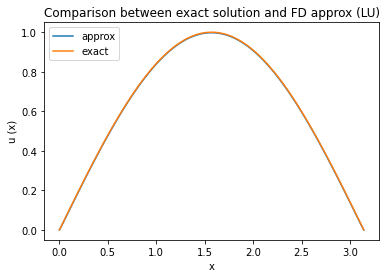

In [11]:
# LU approach
start = timer()
sol = LU_solve(L,U,b)
print("Time spent by back and forw substitution:", timer()-start) 

# exact solution
x_v = np.linspace(omega[0], omega[1], n, dtype=my_type)
sol_ex = np.sin(x_v)

# check
plt.plot(x_v,sol,label="approx")
plt.plot(x_v,sol_ex,label="exact")
plt.title("Comparison between exact solution and FD approx (LU)")
plt.xlabel("x")
plt.ylabel("u (x)")
plt.legend(loc="upper left")

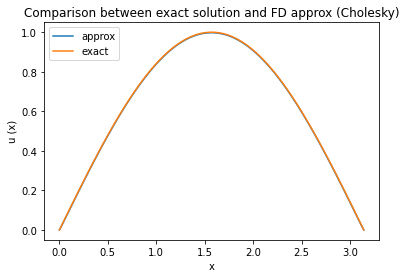

In [12]:
# Cholesky approach
sol = LU_solve(RT, R, b)

# check
plt.plot(x_v,sol,label="approx")
plt.plot(x_v,sol_ex,label="exact")
plt.title("Comparison between exact solution and FD approx (Cholesky)")
plt.xlabel("x")
plt.ylabel("u (x)")
plt.legend(loc="upper left")

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [13]:
def method_errors(f, omega, bc, N, stride, method):
    """Returns the number of grids ,the absolute error asociated with the n_grid
    comparing with the analytical solution and the time spent,
    also you can choose the descomposition method (LU or cholesky)"""
    errors= []
    time_spent= []
    n_grid = np.arange(stride, N+stride, stride, dtype=int)
    for i in n_grid:
        x = np.linspace(omega[0], omega[1], i, dtype=my_type)
        u_an = x**4/12.0 - x**3/6.0 + x/12.0
        
        #SE solver
        A_i, b_i = finDif(omega, f, i, bc)
        start = timer()
        X_i, Y_i = method(A_i)
        u_ap = LU_solve(X_i,Y_i,b_i)
        
        time_spent.append(timer()-start)  #obtain time spent to solve the whole SE
        
        errors.append(np.linalg.norm(abs(u_an - u_ap), np.inf))  #using infinity norm for errors

    return n_grid,errors,time_spent

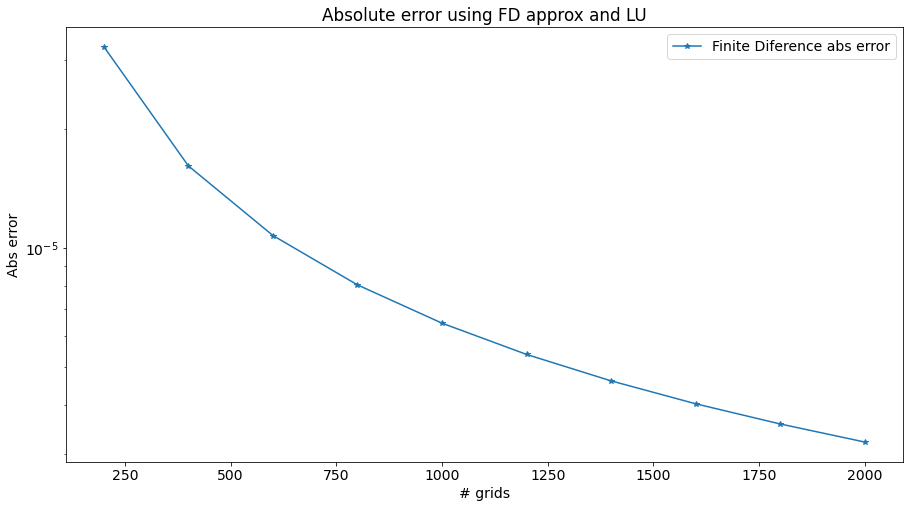

In [20]:
plt.rc('font', size=14) 
plt.figure(figsize=(15,8))
omega = [0,1]
bc = [0,0]
f = lambda x: x*(1-x)  #using lambda functions
n_grid,errors_LU,time_LU = method_errors(f,omega, bc, 2000,200,LU)
#_,_,time_CH = method_errors(f,omega, bc, 2000,200,cholesky)
#_,_,time_optLU = method_errors(f,omega, bc, 2000,200,LU)
#_,_,time_optCH = method_errors(f,omega, bc, 2000,200,cholesky)
#using_GPU=1
#_,_,time_gpuLU = method_errors(f,omega, bc, 2000,200,LU)
#_,_,time_gpuCH = method_errors(f,omega, bc, 2000,200,cholesky)
plt.plot(n_grid, errors_LU, '*-',label="Finite Diference abs error")
plt.title("Absolute error using FD approx and LU")
plt.xlabel("# grids")
plt.ylabel("Abs error")
plt.semilogy()
plt.legend()

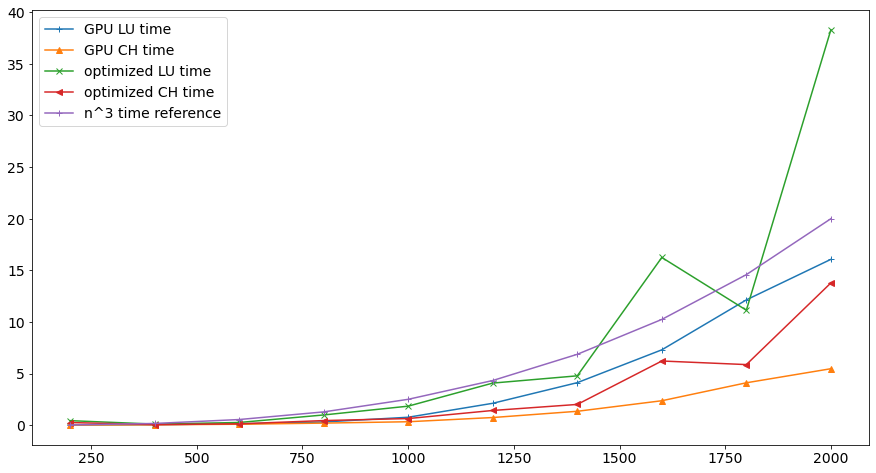

In [91]:
plt.plot(n_grid, time_LU, '*-',label="LU time")
plt.plot(n_grid, time_CH, 'o-',label="CH time")
#plt.plot(n_grid, time_gpuLU, '+-',label="GPU LU time")
#plt.plot(n_grid, time_gpuCH, '^-',label="GPU CH time")
#plt.plot(n_grid, time_optLU, 'x-',label="optimized LU time")
#plt.plot(n_grid, time_optCH, '<-',label="optimized CH time")
#KEEP THE PLOTS PLEASE
plt.plot(n_grid, 2.5e-9*n_grid**3, '+-',label="n^3 time reference")
plt.legend()
plt.savefig('GPU_CPU_comparison.jpg', bbox_inches='tight')

# Here we can observe the time computation comparison between CPU (Using High performance compiler JIT) and GPU, when the # grids (bigger matrix to solve) is bigger than 1000 we noticed the presence of cache resonance, while GPU performance is more stable, as well the complexity time obeys the n^3 curve 

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [18]:
@njit
def obtain_lambdaPM(A,x_k):
        y_k = x_k/np.linalg.norm(x_k,2)
        u_k = np.dot(A,y_k)
        lambda_k = np.dot(y_k.T,u_k)
        return u_k,y_k,lambda_k
    
@njit
def obtain_lambdaIPM(A,L,U,y_k):
        x_k = LU_solve(L,U,y_k)
        return obtain_lambdaPM(A,x_k)

@njit
def Power_Method(A, x_0, tol):
    """This methods allow us to find the bigger eigenvalue of a non-singular matrix
    A within certain tolerance"""
    y_k,_,lambda_k = obtain_lambdaPM(A,x_0)
    cycles = 0
 
    while (True):
        prev_lambda_k = lambda_k
        y_k,_,lambda_k = obtain_lambdaPM(A,y_k)
        error = abs(lambda_k-prev_lambda_k)
        cycles+=1
        if (error<tol and cycles>1e3):
            break

    return lambda_k

@njit
def Inv_Power_Method(A, x_0,shift, tol): 
    """This methods allow us to find the eigenvalues and vector of a non-singular matrix
    A within certain tolerance close to shift 
    (if shift is 0 then will find the minimum eigenvalue)"""
    I = np.eye(len(A[:,]), dtype=my_type)
    A = A - shift*I
    L,U = LU(A)
    y_0 = x_0/np.linalg.norm(x_0,2)
    _,y_k,lambda_k = obtain_lambdaIPM(A,L,U,y_0)
    cycles = 0

    while (True):
        prev_lambda_k = lambda_k
        _,y_k,lambda_k = obtain_lambdaIPM(A,L,U,y_k)   # can obtain eigenvector candidate
        error = abs(lambda_k-prev_lambda_k)
        cycles+=1
        if (error<tol and cycles>1e3):
            break

    return lambda_k , y_k

def condNumb(A):
    """To find the condition number of the matrix we need the maximum and minimum eigenvalue
    In order to exploit the LU method we use the inverse power method"""
    p_0 = np.random.rand(A.shape[0])  #set a random vector to decrease the chance of linear dependency
    start = timer()
    lmax = Power_Method(A, p_0, 1e-3)
    print("Time spent by Power method:", timer()-start) 
    start = timer()
    lmin = Inv_Power_Method(A, p_0, 0, 1e-3)[0]
    print("Time spent by Inverse Power method:", timer()-start) 
    return lmax/lmin

CN= condNumb(A)
print("The condition number is :",CN)
if(np.allclose(np.linalg.cond(A),CN,atol=10)):
    print("Comparing with np library: all good")

Time spent by Power method: 0.016621569986455142
Time spent by Inverse Power method: 0.34399300103541464
The condition number is : 5293.690664015194
Comparing with np library: all good


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [22]:
@njit
def update_p(P,p,r,prev_Pr):
    z = np.linalg.solve(P,r)
    Pr = np.dot(r,z)
    beta = Pr/prev_Pr
    return Pr, beta*p +z

@njit
def update_r(A,p,r,Pr):
    Ap = np.dot(A,p)
    alpha_k = Pr/np.dot(p,Ap)
    return alpha_k, r-alpha_k*Ap

@njit
def conjugate_gradient(A, b, P, nmax=len(A),eps=1e-12):
    """LSE solver using Conjugate gradient method with P as a preconditioner"""
    x = p = np.zeros_like(b, dtype=my_type)
    r = b - np.dot(A,x)
    prev_Pr = 1.0

    cycles = 0
    
    while (True): 
        Pr,p = update_p(P,p,r,prev_Pr)
        alpha_k,r = update_r(A,p,r,Pr)

        x += alpha_k*p
        
        error = np.linalg.norm(r,2)
        cycles += 1
        if(cycles > nmax and error < eps):
            break

        prev_Pr = Pr
    return x


Time spent by Conjugate gradient: 0.025769600993953645


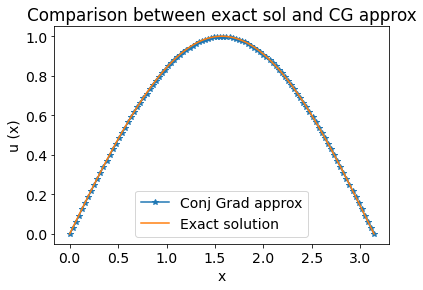

In [24]:
#The preconditioner could be set as the one who can minimize the numerical payload, in this case the diagonal matrix
P = np.diag(np.diag(A))
start = timer()
sol_cg = conjugate_gradient(A, b, P)
print("Time spent by Conjugate gradient:", timer()-start) 
plt.plot(x_v, sol_cg, '*-',label="Conj Grad approx")
plt.plot(x_v, sol_ex,label="Exact solution")
plt.title("Comparison between exact sol and CG approx")
plt.xlabel("x")
plt.ylabel("u (x)")
plt.legend()

In [74]:
def Conj_gradient_times(N,stride):
    """Function that returns a np array with the time spent using CGM for N grids
    with certain stride"""
    time_spent= []
    n_grid = np.arange(stride, N+stride, stride, dtype=int)
    for i in n_grid:
    
        #SE solver
        A_i, b_i = finDif(omega, f, i, bc)
        start = timer()
        P = np.diag(np.diag(A_i))
        conjugate_gradient(A_i, b_i, P)
        
        time_spent.append(timer()-start)  #obtain time spent to solve the whole SE

    return time_spent

In [ ]:
time_CG = Conj_gradient_times(2000,200)

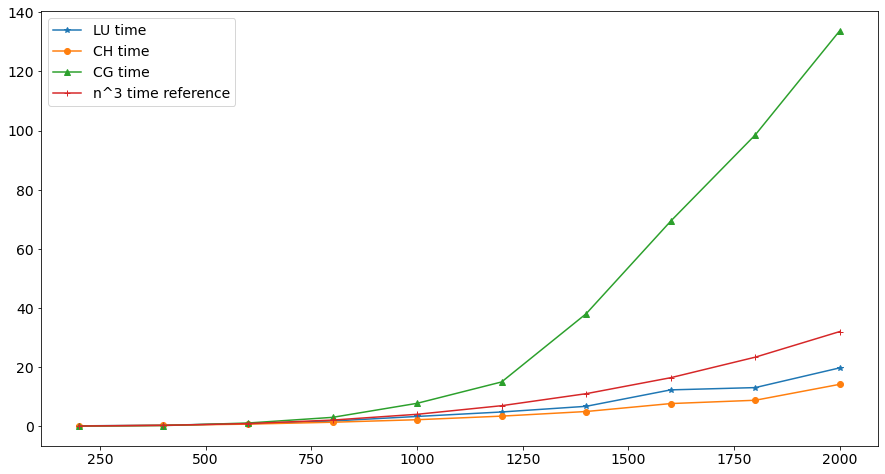

In [87]:
plt.rc('font', size=14) 
plt.figure(figsize=(15,8))
plt.plot(n_grid, time_LU, '*-',label="LU time")
plt.plot(n_grid, time_CH, 'o-',label="CH time")
plt.plot(n_grid, time_CG, '^-',label="CG time")
plt.plot(n_grid, 4.0e-9*n_grid**3, '+-',label="n^3 time reference")
plt.legend()
plt.savefig('time_methods.jpg', bbox_inches='tight')

# Here we can observe the time computation comparison between different SE solvers (LU fact, Cholesky and Conjugate gradient)

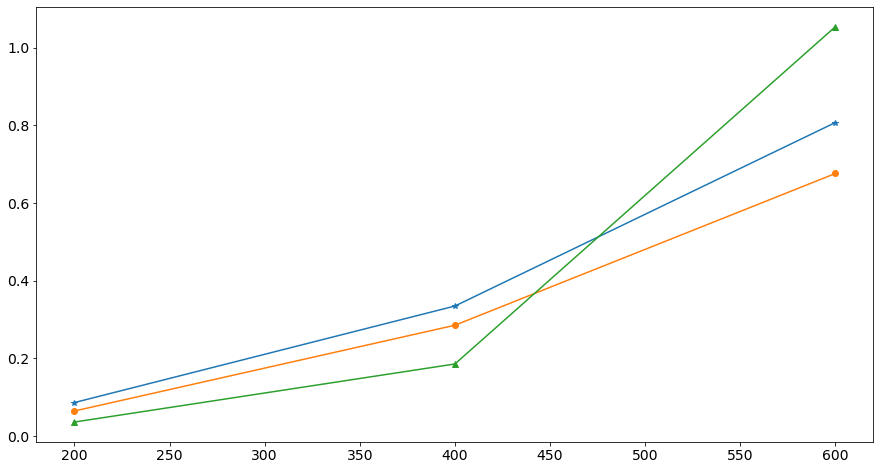

In [86]:
plt.rc('font', size=14) 
plt.figure(figsize=(15,8))
plt.plot(n_grid[0:3], time_LU[0:3], '*-',label="LU time")
plt.plot(n_grid[0:3], time_CH[0:3], 'o-',label="CH time")
plt.plot(n_grid[0:3], time_CG[0:3], '^-',label="CG time")

# Conjugate gradient method as it is a iterative method tends to perform much better for smaller matrices than direct methods, but as soon the # grids starts to grow this method has a poorly performance overall

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [25]:
def F_Euler_Method(A, b, u_0, T, h, alpha):  #taking advantage of the previous calculated matrices
    """Forward Euler method to solve PDE , A as the finite difference associated matrix
    b as the function vector, u_0 initial conditions, T the time frame, h the step and alpha
    a random function"""
    t_0,t_f = T
    N = int(np.ceil((t_f-t_0)/h))  #number of timesteps
    if (N<3):
        raise Exception("Better choose other h")
        
    t = np.linspace(t_0,t_f, N)      
    M_sol = np.empty((N,len(u_0)), dtype=my_type)    # Matrix solution (rows=timestep)
    M_sol[0,:] = u_0
                   
    for i in range(1,N):
        u_xx = -np.dot(A,M_sol[i-1])     # derivative at time t_i
        alpha_b = np.dot(alpha(t[i-1]),b)        # computation of function at time t_i
        M_sol[i] = M_sol[i-1] + h*u_xx + h*alpha_b     #one step ahead in time

    return M_sol, t

# Arguments
T = [0,6*np.pi]
alpha = lambda x: np.cos(x)

# the inverse of the max_eigenvalue is a good option for a step
p_0 = np.random.rand(A.shape[0])
max_eigen=Power_Method(A, p_0,1e-3) 
h = 1/max_eigen

# Considering initial conditions u_0 = sin(x)
u_0 = np.sin(x_v)

# time_indexes
omega = [0,np.pi] #original omega
width = omega[1] - omega[0]
x_pi2 = int(np.floor((n*np.pi)/(width*2))) -1
x_1 = int(np.floor(n/width)) -1
x_pi = int(np.floor(n*np.pi/width)) -1

Time spent to obtain solution using Forward Euler: 1.1563329650089145


Text(0, 0.5, 'u (x)')

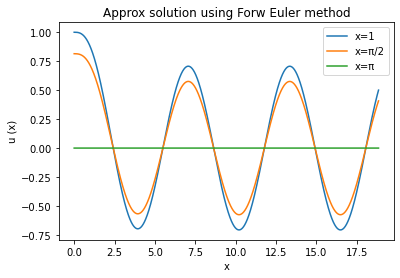

In [28]:
plt.rc('font', size=10) 
start = timer()
M_sol, t = F_Euler_Method(A,b,u_0,T, h,alpha)
print("Time spent to obtain solution using Forward Euler:", timer()-start)
plt.plot(t, M_sol[:,x_pi2], label='x=1')
plt.plot(t, M_sol[:,x_1], label='x=π/2')
plt.plot(t, M_sol[:,x_pi], label='x=π')
plt.legend(loc='upper right')
plt.title("Approx solution using Forw Euler method")
plt.xlabel("x")
plt.ylabel("u (x)")

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [106]:
@njit
def comp_eigenvalues(A, tol, nmax=100):
    """Returns all the approximate eigenvalues exploiting LU decomposition"""
    _A = A.copy()
    candidates_ev = np.diag(_A)
    cycles = 0
    
    while (True):
        L, U = LU(_A)
        _A = U@L
        eigenvalues = np.diag(_A)  
        err = np.linalg.norm(eigenvalues-candidates_ev,2)
        cycles += 1
        
        if(err<tol and cycles>nmax):
            break
        
        candidates_ev = eigenvalues
        
    return eigenvalues

@njit
def comp_all_eigenv(A, tol):
    """Returns approximate eigenvectors using inverse power method (shift) which uses LU as well
    For this method there is a caveat, When there are DEGENERATE eigenvalues it will return a 
    vector which is a linear combination of the degenerate eigenvectors :( """
    eigenvalues = comp_eigenvalues(A,tol)
    eigenv_matrix = np.empty_like(A, dtype=my_type)
    p_0 = np.random.rand(A.shape[0])
    n = len(eigenvalues)

    for i in range(n):
        _, eigenvector = Inv_Power_Method(A, p_0, eigenvalues[i]+tol,tol)
        eigenv_matrix[i,:] = eigenvector
         
    return eigenvalues, eigenv_matrix

start = timer()
eigenvalues,eigenvectors = comp_all_eigenv(A, 1e-3)
print("Time spent to obtain eigenvalues and eigenvector:", timer()-start) 

Time spent to obtain eigenvalues and eigenvector: 42.521986273997754


Compute the inverse of the matrix A exploiting the derived LU factorization

In [19]:
@njit
def inverse_using_LU(A):
    """Returns the inverse matrix of A (NxN) by solving N linear SE using LU"""
    N = len(A[:,])
    L, U = LU(A)
    inv_A = np.empty_like(A, dtype=my_type)
    I = np.eye(N, dtype=my_type)
    
    for i in range(N):
        inv_i = LU_solve(L,U,I[:,i])
        inv_A[:,i] = inv_i
    return inv_A

start = timer()
inv_A = inverse_using_LU(A)
print("Time spent to obtain inverse of a matrix:", timer()-start)

if(np.allclose(inv_A,np.linalg.inv(A),atol=1e-15)):
    print("Comparing with np library : all good")

Time spent to obtain inverse of a matrix: 0.04712753801140934
Comparing with np library : all good


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

Time spent to solve PDE using Backward Euler method: 0.08396096096839756


Text(0, 0.5, 'y (x)')

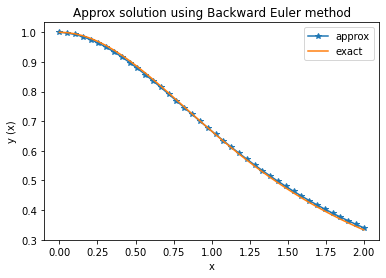

In [29]:
#cannot use njit if lambda function is an argument
def Newton_Method(f, f_derivative, x, tol, n_max=1000):
    """Returns a root of the function f within certain tolerance using Newton method"""
    cycles = 0
    while (True):
        f_px = f_derivative(x)
        
        if(abs(f_px)<tol):
            raise ValueError("We obtained a value too close to 0 as denominator")

        x -= f(x)/f_px
        
        error = abs(f(x))   # residual control
        cycles += 1
        if(error < tol and cycles > n_max):
            break

    return x

def Bw_Euler_Method(y_0, T, h, report_time=0):
    """Returns the spatial and time solution of a PDE using BW euler method where y_0
    is the initial condition, T the time frame and h the step"""
    start = timer()
    t_0,t_f = T
    N = int(np.ceil((t_f-t_0)/h))  #number of timesteps
    if (N<3):
        raise Exception("Better choose other h")
    
    t = np.linspace(t_0,t_f, N) 
    y_k = np.empty_like(t, dtype=my_type)
    y_k[0] = y_0
    
    for i in range(1, N):
        f = lambda y: t[i]*h*y*y + y - y_k[i-1]    # looking for zeros considering y' = (y[i]-y[i-1]/h)
        f_derivative = lambda y: 2*t[i]*h*y + 1
        y_k[i] = Newton_Method(f, f_derivative, 1e-6, y_k[i-1])
    if(report_time):
        print("Time spent to solve PDE using Backward Euler method:", timer()-start) 
    return y_k, t

# Initial conditions
T = [0.0,2.0]
y_0 = 1.0

y, t = Bw_Euler_Method(y_0, T, 0.05,1)

#Analytic solution
y_ex = 2.0/(t*t + 2.0)

plt.plot(t, y, '*-',label="approx")
plt.plot(t, y_ex,label="exact")
plt.legend()
plt.title("Approx solution using Backward Euler method")
plt.xlabel("x")
plt.ylabel("y (x)")